In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

# Display the version
print(tf.__version__)

# import and mount Drive
import os
from google.colab import drive
drive.mount('/content/gdrive')

2.13.0
Mounted at /content/gdrive


In [2]:
# get path to folder file is in
!pip install kora
from kora.drive import get_path
file_path = get_path('17rNCLBHSPszyoaacFSpsFGD5nlP1OBF7')
file_path = '/content/gdrive/' + str(file_path) + '/CIFAR-100'
print(file_path)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.1 MB/s eta 0:00:00
/content/gdrive/My Drive/Personal Projects/Pioneer Academics Research/code/CIFAR-100


In [3]:
# Download the data from tf, unless it's already here.
if not os.path.exists(file_path+'/data/clean'):
  os.mkdir(file_path+'/data/clean')
  (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()
  np.save(file_path+'/data/clean/X_train.npy',X_train)
  np.save(file_path+'/data/clean/y_train.npy',y_train)
  np.save(file_path+'/data/clean/X_test.npy',X_test)
  np.save(file_path+'/data/clean/y_test.npy',y_test)
else:
  X_train = np.load(file_path+'/data/clean/X_train.npy')
  y_train = np.load(file_path+'/data/clean/y_train.npy')
  X_test = np.load(file_path+'/data/clean/X_test.npy')
  y_test = np.load(file_path+'/data/clean/y_test.npy')

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (50000, 32, 32, 3)
y_train shape (50000, 1)
X_test shape (10000, 32, 32, 3)
y_test shape (10000, 1)


In [4]:
# Convert to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Decrease pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

In [5]:
# Load in Clean Model
model = tf.keras.models.load_model(file_path+'/models/clean.keras')

In [6]:
# Create FGSM Perturbed Data
def create_fgsm_perturbations(data_inputs, data_labels, epsilon = 0.1):
  input_tensor = tf.convert_to_tensor(data_inputs)
  label_tensor = tf.convert_to_tensor(data_labels)
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
  with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    output_tensor = model(input_tensor)
    loss = loss_fn(label_tensor, output_tensor)

  gradient = tape.gradient(loss, input_tensor)
  perturbed_input_tensor = input_tensor + epsilon * tf.sign(gradient)
  return tf.cast(perturbed_input_tensor, dtype=input_tensor.dtype)

# Create FGSM perturbations if nonexisting, else load them
if not os.path.exists(file_path+'/data/FGSM_perturbed'):
  os.mkdir(file_path+'/data/FGSM_perturbed')

  perturbed_data = [None for _ in range(5)]
  for i in range(5):
    perturbed_data[i] = create_fgsm_perturbations(X_train[i * 10000:(i+1) * 10000], y_train[i * 10000:(i+1) * 10000])

  X_FGSM_train = np.concatenate(perturbed_data, axis=0)
  X_FGSM_test = create_fgsm_perturbations(X_test, y_test)

  np.save(file_path+'/data/FGSM_perturbed/X_FGSM_train.npy',X_FGSM_train)
  np.save(file_path+'/data/FGSM_perturbed/X_FGSM_test.npy',X_FGSM_test)
else:
  X_FGSM_train = np.load(file_path+'/data/FGSM_perturbed/X_FGSM_train.npy')
  X_FGSM_test = np.load(file_path+'/data/FGSM_perturbed/X_FGSM_test.npy')

print("X_FGSM_train shape", X_FGSM_train.shape)
print("y_train shape", y_train.shape)
print("X_FGSM_test shape", X_FGSM_test.shape)
print("y_test shape", y_test.shape)

X_FGSM_train shape (50000, 32, 32, 3)
y_train shape (50000, 1)
X_FGSM_test shape (10000, 32, 32, 3)
y_test shape (10000, 1)


In [7]:
# Clip perturbed training and test data to viable values
X_FGSM_train = np.clip(X_FGSM_train, a_min = 0.0, a_max = 1.0)
X_FGSM_test = np.clip(X_FGSM_test, a_min = 0.0, a_max = 1.0)

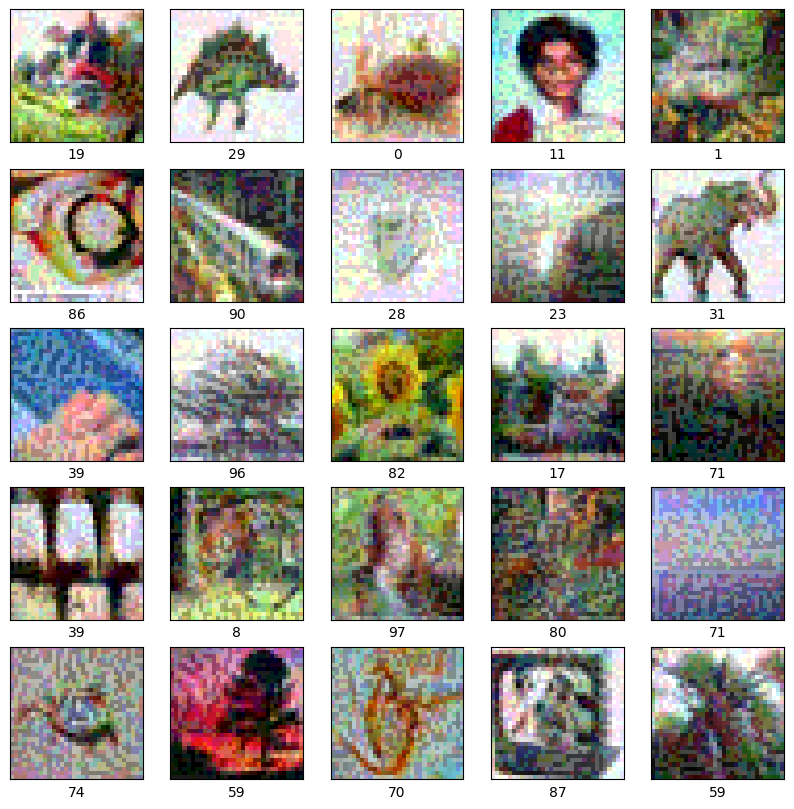

In [8]:
# Display training images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_FGSM_train[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(y_train[i][0])
plt.show()

In [9]:
model.evaluate(X_FGSM_train, y_train)
model.evaluate(X_FGSM_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 8.0623 - accuracy: 0.0155


[8.062313079833984, 0.01549999974668026]

In [10]:
# Create PGD Perturbed Data
def create_pgd_perturbations(data_inputs, data_labels, epsilon = 0.01, n_iter = 10):
  input_tensor = tf.convert_to_tensor(data_inputs)
  label_tensor = tf.convert_to_tensor(data_labels)
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

  perturbed_tensor = input_tensor
  for i in range(n_iter):
      with tf.GradientTape() as tape:
          tape.watch(perturbed_tensor)
          output_tensor = model(perturbed_tensor)
          loss = loss_fn(label_tensor, output_tensor)

      gradient = tape.gradient(loss, perturbed_tensor)

      perturbed_tensor = perturbed_tensor + gradient
      # Project perturbed_tensor onto the L-infinity ball around input_tensor
      perturbed_tensor = epsilon * tf.sign(
          perturbed_tensor - input_tensor) + input_tensor

  perturbed_tensor = tf.cast(perturbed_tensor, dtype=input_tensor.dtype)
  return perturbed_tensor

# Create PGD perturbations if nonexisting, else load them
if not os.path.exists(file_path+'/data/PGD_perturbed'):
  os.mkdir(file_path+'/data/PGD_perturbed')

  perturbed_data = [None for _ in range(5)]
  for i in range(5):
    perturbed_data[i] = create_fgsm_perturbations(X_train[i * 10000:(i+1) * 10000], y_train[i * 10000:(i+1) * 10000])

  X_PGD_train = np.concatenate(perturbed_data, axis=0)
  X_PGD_test = create_pgd_perturbations(X_test, y_test)

  np.save(file_path+'/data/PGD_perturbed/X_PGD_train.npy',X_PGD_train)
  np.save(file_path+'/data/PGD_perturbed/X_PGD_test.npy',X_PGD_test)
else:
  X_PGD_train = np.load(file_path+'/data/PGD_perturbed/X_PGD_train.npy')
  X_PGD_test = np.load(file_path+'/data/PGD_perturbed/X_PGD_test.npy')

print("X_PGD_train shape", X_PGD_train.shape)
print("y_train shape", y_train.shape)
print("X_PGD_test shape", X_PGD_test.shape)
print("y_test shape", y_test.shape)

X_PGD_train shape (50000, 32, 32, 3)
y_train shape (50000, 1)
X_PGD_test shape (10000, 32, 32, 3)
y_test shape (10000, 1)


In [11]:
# Clip perturbed training and test data to viable values
X_PGD_train = np.clip(X_PGD_train, a_min = 0.0, a_max = 1.0)
X_PGD_test = np.clip(X_PGD_test, a_min = 0.0, a_max = 1.0)

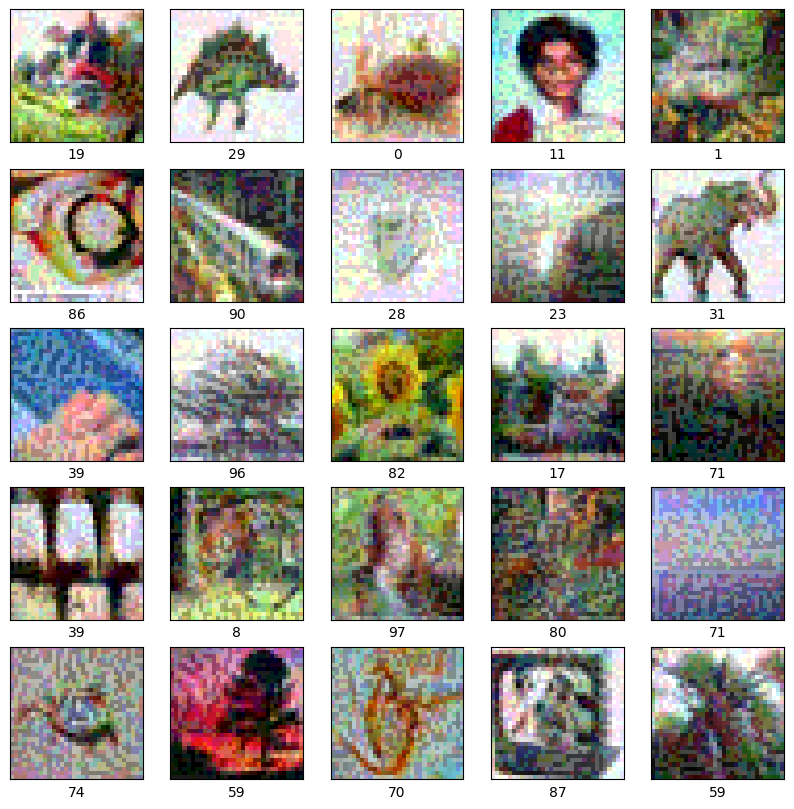

In [12]:
# Display training images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_PGD_train[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(y_train[i][0])
plt.show()

In [13]:
model.evaluate(X_PGD_train, y_train)
model.evaluate(X_PGD_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 4.3931 - accuracy: 0.1714


[4.393067836761475, 0.17139999568462372]

In [14]:
print(X_train.shape[1:])

(32, 32, 3)


In [15]:
# Implement the chosen values in a final model, from https://github.com/rajeevsahay/ae-defenses/blob/master/Semi-white_Box_Attack_(FGSM)/pp_auto_encoder_fgsm.py
def train_autoencoder(data_total_train, data_total_test, labels_total_train = np.concatenate([X_train, X_train], axis=0), labels_total_test = np.concatenate([X_test, X_test], axis=0), file_name=(file_path + '/models/denoising_autoencoder.keras'), num_epochs = 25, batch_size=256, lr=0.0003):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=data_total_train.shape[1:]))
    model.add(tf.keras.layers.Dense(256, activation=None, use_bias=True, kernel_initializer="uniform"))
    model.add(tf.keras.layers.Dense(128, activation=None, kernel_initializer="uniform"))
    model.add(tf.keras.layers.Dense(64, activation=None, kernel_initializer="uniform"))
    model.add(tf.keras.layers.Dense(128, activation=None, kernel_initializer="uniform"))
    model.add(tf.keras.layers.Dense(256, activation=None, kernel_initializer="uniform"))
    model.add(tf.keras.layers.Dense(3072, activation="sigmoid", kernel_initializer="uniform"))
    model.add(tf.keras.layers.Reshape(data_total_train.shape[1:]))

    #Compile model using mean squared error as loss and adam as optimizer
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])

    #Train model using input of clean and corrupted data and fit to clean reconstructions only
    model.fit(data_total_train, labels_total_train, validation_data=(data_total_test, labels_total_test), epochs=num_epochs, batch_size=batch_size, shuffle=True, verbose=1)

    model.summary()

    if file_name != None:
        model.save(file_name)

    return model

In [16]:
# Run model on FGSM and clean data
FGSM_denoising_autoencoder = train_autoencoder(np.concatenate([X_train, X_FGSM_train], axis=0), np.concatenate([X_test, X_FGSM_test], axis=0), file_name=(file_path + '/models/FGSM_denoising_autoencoder.keras'))

Epoch 1/25
391/391 [==============================] - 6s 8ms/step - loss: 0.0445 - accuracy: 0.5625 - val_loss: 0.0318 - val_accuracy: 0.6249
Epoch 2/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0282 - accuracy: 0.6191 - val_loss: 0.0267 - val_accuracy: 0.6277
Epoch 3/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0244 - accuracy: 0.6195 - val_loss: 0.0239 - val_accuracy: 0.6256
Epoch 4/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0222 - accuracy: 0.6471 - val_loss: 0.0216 - val_accuracy: 0.6686
Epoch 5/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0209 - accuracy: 0.6691 - val_loss: 0.0202 - val_accuracy: 0.6668
Epoch 6/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0194 - accuracy: 0.6802 - val_loss: 0.0191 - val_accuracy: 0.6920
Epoch 7/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0182 - accuracy: 0.6951 - val_loss: 0.0183 - val_accuracy: 0.6991
Epoch 

In [17]:
# Evaluate original model on a set the model has never seen
model.evaluate(X_FGSM_test, y_test)

# Evaluate it on a set the model has never seen
model.evaluate(FGSM_denoising_autoencoder.predict(X_FGSM_test), y_test)

313/313 [==============================] - 1s 3ms/step - loss: 6.1387 - accuracy: 0.0810


[6.138703346252441, 0.08100000023841858]

In [18]:
# Run model on PGD and clean data
PGD_denoising_autoencoder = train_autoencoder(np.concatenate([X_train, X_PGD_train], axis=0), np.concatenate([X_test, X_PGD_test], axis=0), file_name=(file_path + '/models/PGD_denoising_autoencoder.keras'))

Epoch 1/25
391/391 [==============================] - 5s 9ms/step - loss: 0.0441 - accuracy: 0.5563 - val_loss: 0.0318 - val_accuracy: 0.6274
Epoch 2/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0281 - accuracy: 0.6192 - val_loss: 0.0270 - val_accuracy: 0.6210
Epoch 3/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0247 - accuracy: 0.6220 - val_loss: 0.0230 - val_accuracy: 0.6199
Epoch 4/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0222 - accuracy: 0.6477 - val_loss: 0.0222 - val_accuracy: 0.6566
Epoch 5/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0214 - accuracy: 0.6577 - val_loss: 0.0212 - val_accuracy: 0.6602
Epoch 6/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0199 - accuracy: 0.6777 - val_loss: 0.0195 - val_accuracy: 0.7066
Epoch 7/25
391/391 [==============================] - 2s 6ms/step - loss: 0.0187 - accuracy: 0.6963 - val_loss: 0.0181 - val_accuracy: 0.7028
Epoch 

In [19]:
# Evaluate original model on a set the model has never seen
model.evaluate(X_FGSM_test, y_test)

# Evaluate it on a set the model has never seen
model.evaluate(PGD_denoising_autoencoder.predict(X_PGD_test), y_test)

313/313 [==============================] - 1s 3ms/step - loss: 5.8620 - accuracy: 0.1000


[5.8619890213012695, 0.10000000149011612]